In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasetCleaner import *
from YUVHandler import *
from pixelFeatures import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [3]:
df = pd.read_csv('../datasets/features/dataset_Beauty_1080p_22_features.csv')
df

,videoname,cost,frameWidth,frameHeight,paramQP,CU_width,CU_height,topLeft_x,topLeft_y,bottomRight_x,...,quarter3GradH,quarter3GradV,quarter3RatioGrad,quarter3Sum,quarter4Var,quarter4Mean,quarter4GradH,quarter4GradV,quarter4RatioGrad,quarter4Sum
0,Beauty_1080p,1.700000e+308,1920,1080,22,128,128,0,0,127,...,2560,63936,0.040040,463860.0,154.449,118.925,2752,192,14.33330,487116.0
1,Beauty_1080p,3.264370e+08,1920,1080,22,64,64,0,0,63,...,1024,65344,0.015671,116400.0,146.334,114.098,224,800,0.28000,116836.0
2,Beauty_1080p,7.182820e+07,1920,1080,22,32,32,0,0,31,...,96,64800,0.001481,29504.0,138.562,114.250,1696,192,8.83333,29248.0
3,Beauty_1080p,1.942200e+07,1920,1080,22,16,16,0,0,15,...,-1,-1,-1.000000,-1.0,-1.000,-1.000,-1,-1,-1.00000,-1.0
4,Beauty_1080p,9.702730e+06,1920,1080,22,16,8,0,0,15,...,-1,-1,-1.000000,-1.0,-1.000,-1.000,-1,-1,-1.00000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649407,Beauty_1080p,1.279520e+06,1920,1080,22,8,8,1904,1072,1911,...,-1,-1,-1.000000,-1.0,-1.000,-1.000,-1,-1,-1.00000,-1.0
2649408,Beauty_1080p,8.379820e+05,1920,1080,22,8,8,1912,1072,1919,...,-1,-1,-1.000000,-1.0,-1.000,-1.000,-1,-1,-1.00000,-1.0
2649409,Beauty_1080p,8.379820e+05,1920,1080,22,8,8,1912,1072,1919,...,-1,-1,-1.000000,-1.0,-1.000,-1.000,-1,-1,-1.00000,-1.0
2649410,Beauty_1080p,8.379820e+05,1920,1080,22,8,8,1912,1072,1919,...,-1,-1,-1.000000,-1.0,-1.000,-1.000,-1,-1,-1.00000,-1.0


In [5]:
videos = ['Vidyo4', 'Dark', 'NetflixDinnerScene', 'KristenAndSara', 'Netflix_DrivingPOV']
qps = ['22', '27', '32','37']

vtm = pd.DataFrame()
for video in videos:
    for qp in qps:

        df_features = pd.read_csv('../datasets/features/dataset_' + video + '_' + qp + '_features.csv')
        height = df_features['frameHeight'].iloc[0]
        width = df_features['frameWidth'].iloc[0]
        df_features = df_features.query('CU_width == 128 & CU_height == 128 & POC > 0 & bottomRight_x < @width & bottomRight_y < @height & bottomRight_x > 0 & bottomRight_y > 0')
        df_features.drop_duplicates(inplace = True)
        df_features.reset_index(drop = True, inplace = True)

        df_target = pd.read_csv('../datasets/target/dataset_' + video + '_' + qp + '_target.csv')

        height = df_target['frameHeight'].iloc[0]
        width = df_target['frameWidth'].iloc[0]

        df_target = df_target.query('CU_width == 128 & CU_height == 128 & POC > 0 & bottomRight_x < @width & bottomRight_y < @height & bottomRight_x > 0 & bottomRight_y > 0')
        df_target = df_target.groupby(by=['videoname','paramQP','frameWidth','frameHeight','CU_width','CU_height','topLeft_x','topLeft_y','bottomRight_x','bottomRight_y','POC','qtdepth','mtdepth','splitType']).min()
        df_target = df_target.reset_index()
        df_target = df_target.drop_duplicates()

        df = pd.merge(df_features, df_target, on=['videoname','paramQP','frameWidth','frameHeight','CU_width','CU_height','topLeft_x','topLeft_y','bottomRight_x','bottomRight_y','POC','qtdepth','mtdepth','splitType'])

        del df_features
        del df_target

        df.drop_duplicates(inplace = True)
        df.reset_index(inplace = True, drop = True)
        df['target'] = df['cost'] > df['RDCost']
        df['target'] = df['target'].apply(lambda x : 1 if x else 0)
        df = df.drop(columns = ['cost', 'RDCost'])
        splits = ['QT_SPLIT', 'BI_HORZ', 'BI_VERT', 'TRI_HORZ', 'TRI_VERT']
        for i in range(len(splits)):
            df['splitType'] = df['splitType'].replace(i+1, splits[i])
        vtm = pd.concat([vtm, df])
vtm.to_csv('../datasets/all/VTM_s0.csv', index = False)

In [ ]:
df = pd.read_csv('../datasets/all/VTM_s0.csv')
splits = ['QT_SPLIT', 'BI_HORZ', 'BI_VERT', 'TRI_HORZ', 'TRI_VERT']

for split in splits:
    aux = df[df['splitType'] == split]
    aux.replace([np.inf, -np.inf], np.nan, inplace=True)
    aux.dropna(inplace = True)
    aux.to_csv('../datasets/' + split + '/s0.csv', index = False)

In [59]:
df = pd.read_csv('../datasets/QT_SPLIT/s0.csv')

df['HIVar'] = abs(df['quarter1Var'] - df['quarter2Var']) + abs(df['quarter3Var'] - df['quarter4Var'])
df['HIMean'] = abs(df['quarter1Mean'] - df['quarter2Mean']) + abs(df['quarter3Mean'] - df['quarter4Mean'])
df['HIRatioGrad'] = abs(df['quarter1RatioGrad'] - df['quarter2RatioGrad']) + abs(df['quarter3RatioGrad'] - df['quarter4RatioGrad'])

df['VIVar'] = abs(df['quarter1Var'] - df['quarter3Var']) + abs(df['quarter2Var'] - df['quarter4Var'])
df['VIMean'] = abs(df['quarter1Mean'] - df['quarter3Mean']) + abs(df['quarter2Mean'] - df['quarter4Mean'])
df['VIRatioGrad'] = abs(df['quarter1RatioGrad'] - df['quarter3RatioGrad']) + abs(df['quarter2RatioGrad'] - df['quarter4RatioGrad'])

df['DiffInconsVar'] = abs(df['HIVar'] - df['VIVar'])
df['DiffInconsMean'] = abs(df['HIMean'] - df['VIMean'])
df['DiffInconsRatioGrad'] = abs(df['HIRatioGrad'] - df['VIRatioGrad'])
df.to_csv('../datasets/QT_SPLIT/s0.csv', index = False)

In [57]:
df = pd.read_csv('../datasets/QT_SPLIT/s0.csv')
df

,videoname,frameWidth,frameHeight,paramQP,CU_width,CU_height,topLeft_x,topLeft_y,bottomRight_x,bottomRight_y,...,quarter3GradV,quarter3RatioGrad,quarter3Sum,quarter4Var,quarter4Mean,quarter4GradH,quarter4GradV,quarter4RatioGrad,quarter4Sum,target
0,Vidyo4,1280,720,22,128,128,1152,128,1279,255,...,63360,1.025760,3844000.0,7.99945,936.023,1280,63072,0.020294,3833950.0,1
1,Vidyo4,1280,720,22,128,128,0,0,127,127,...,62944,0.338587,1513960.0,2427.75000,399.983,17472,54496,0.320611,1638330.0,0
2,Vidyo4,1280,720,22,128,128,1024,0,1151,127,...,61664,0.847431,2994460.0,7989.53000,829.620,48960,65152,0.751473,3398120.0,1
3,Vidyo4,1280,720,22,128,128,768,128,895,255,...,33632,0.320647,1920840.0,37598.60000,417.395,26784,44128,0.606962,1709650.0,1
4,Vidyo4,1280,720,22,128,128,1024,128,1151,255,...,38304,0.914787,1693520.0,12104.00000,818.528,28320,43712,0.647877,3352690.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8125,Netflix_DrivingPOV,1280,720,37,128,128,384,512,511,639,...,54752,1.121570,1910830.0,155.57600,462.221,64896,58656,1.106380,1893260.0,0
8126,Netflix_DrivingPOV,1280,720,37,128,128,512,512,639,639,...,55424,0.022517,1894460.0,173.85700,461.556,352,60384,0.005829,1890530.0,0
8127,Netflix_DrivingPOV,1280,720,37,128,128,768,512,895,639,...,57792,1.090810,1883220.0,209.70800,449.308,59648,54432,1.095830,1840360.0,1
8128,Netflix_DrivingPOV,1280,720,37,128,128,896,512,1023,639,...,53568,0.117085,1848290.0,219.95800,458.949,65088,60640,1.073350,1879860.0,0


In [45]:
X = df.drop(columns = ['target'])
y = df['target']

constant_filter = VarianceThreshold(threshold = 0.01)
constant_filter.fit(X)
xFilter = constant_filter.transform(X)
columnsFilter = X.columns[constant_filter.get_support()]

x_T = xFilter.T
x_T = pd.DataFrame(x_T)

duplicatedFeatures = x_T.duplicated()
featuresToKeep = [not index for index in duplicatedFeatures]

xUnique = x_T[featuresToKeep].T
columnsUnique = columnsFilter[featuresToKeep]

xUnique.columns = columnsUnique
X = xUnique

fs = SelectKBest(score_func = f_classif, k = round((X.shape[1]*0.2)))
X_selected = fs.fit_transform(X, y)

forest = RandomForestClassifier(n_estimators = 10, max_depth = 10, random_state = 0)
scores = cross_val_score(forest, X_selected, y, cv = 5, n_jobs = 4)
print('Score: ', scores.mean())

columnsFilter = X.columns[fs.get_support()]
columnsFilter

Score:  0.5210332103321034


Index(['quarter1GradH', 'quarter1RatioGrad', 'quarter2GradH',
       'quarter2RatioGrad', 'quarter3RatioGrad', 'quarter4RatioGrad',
       'HIRatioGrad', 'VIRatioGrad', 'DiffInconsRatioGrad'],
      dtype='object')

In [63]:
df = pd.read_csv('../datasets/BI_VERT/s0.csv')
df['HIVIVar'] = abs(df['quarter1Var'] - df['quarter2Var'])
df['HIVIMean'] = abs(df['quarter1Mean'] - df['quarter2Mean'])
df['HIVIRatioGrad'] = abs(df['quarter1RatioGrad'] - df['quarter2RatioGrad'])
df.to_csv('../datasets/BI_VERT/s0.csv', index = False)

In [64]:
df = pd.read_csv('../datasets/BI_VERT/s0.csv')
df

,videoname,frameWidth,frameHeight,paramQP,CU_width,CU_height,topLeft_x,topLeft_y,bottomRight_x,bottomRight_y,...,quarter4Var,quarter4Mean,quarter4GradH,quarter4GradV,quarter4RatioGrad,quarter4Sum,target,HIVIVar,HIVIMean,HIVIRatioGrad
0,Vidyo4,1280,720,22,128,128,1152,128,1279,255,...,-1.0,-1.0,-1,-1,-1.0,-1.0,1,5.79199,1.773,0.999590
1,Vidyo4,1280,720,22,128,128,1024,0,1151,127,...,-1.0,-1.0,-1,-1,-1.0,-1.0,1,7725.83860,95.210,77.361410
2,Vidyo4,1280,720,22,128,128,1152,0,1279,127,...,-1.0,-1.0,-1,-1,-1.0,-1.0,0,4.36881,0.519,7.771670
3,Vidyo4,1280,720,22,128,128,768,128,895,255,...,-1.0,-1.0,-1,-1,-1.0,-1.0,1,7942.80000,30.558,0.863045
4,Vidyo4,1280,720,22,128,128,1024,128,1151,255,...,-1.0,-1.0,-1,-1,-1.0,-1.0,1,35966.30000,287.332,3.351183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8466,Netflix_DrivingPOV,1280,720,37,128,128,384,512,511,639,...,-1.0,-1.0,-1,-1,-1.0,-1.0,0,2779.90000,19.196,1.888473
8467,Netflix_DrivingPOV,1280,720,37,128,128,512,512,639,639,...,-1.0,-1.0,-1,-1,-1.0,-1.0,0,5027.38000,18.947,0.069211
8468,Netflix_DrivingPOV,1280,720,37,128,128,768,512,895,639,...,-1.0,-1.0,-1,-1,-1.0,-1.0,1,1497.69000,0.579,0.667593
8469,Netflix_DrivingPOV,1280,720,37,128,128,896,512,1023,639,...,-1.0,-1.0,-1,-1,-1.0,-1.0,0,881.01000,26.426,72.871550


In [55]:
df.drop(columns = ['videoname', 'splitType'], inplace = True)
X = df.drop(columns = ['target'])
y = df['target']

constant_filter = VarianceThreshold(threshold = 0.01)
constant_filter.fit(X)
xFilter = constant_filter.transform(X)
columnsFilter = X.columns[constant_filter.get_support()]

x_T = xFilter.T
x_T = pd.DataFrame(x_T)

duplicatedFeatures = x_T.duplicated()
featuresToKeep = [not index for index in duplicatedFeatures]

xUnique = x_T[featuresToKeep].T
columnsUnique = columnsFilter[featuresToKeep]

xUnique.columns = columnsUnique
X = xUnique

fs = SelectKBest(score_func = f_classif, k = round((X.shape[1]*0.2)))
X_selected = fs.fit_transform(X, y)

forest = RandomForestClassifier(n_estimators = 10, max_depth = 10, random_state = 0)
scores = cross_val_score(forest, X_selected, y, cv = 5, n_jobs = -1)
print('Score: ', scores.mean())

columnsFilter = X.columns[fs.get_support()]
columnsFilter

Score:  0.514813260082552


Index(['paramQP', 'quarter2GradV', 'quarter2RatioGrad', 'HIVIMean',
       'HIVIRatioGrad'],
      dtype='object')

In [56]:
columnsFilter[0]

'paramQP'

In [ ]:
df = pd.read_csv('../datasets/all/VTM_s0.csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace = True)
df = df[(df['splitType'] == 'BI_HORZ')]

df['HIVIVar'] = abs(df['quarter1Var'] - df['quarter2Var'])
df['HIVIMean'] = abs(df['quarter1Mean'] - df['quarter2Mean'])
df['HIVIRatioGrad'] = abs(df['quarter1RatioGrad'] - df['quarter2RatioGrad'])
df

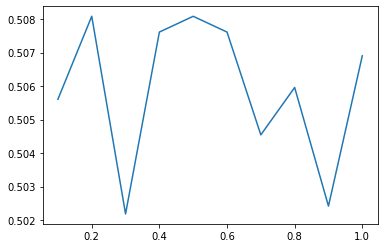

In [24]:
kBest = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
values = []
for k in kBest:

    fs = SelectKBest(score_func = f_classif, k = round((X.shape[1]*k)))
    X_selected = fs.fit_transform(X, y)

    forest = RandomForestClassifier(random_state = 0)
    scores = cross_val_score(forest, X_selected, y, cv = 5, n_jobs = 4)
    values.append(scores.mean())
plt.plot(kBest, values);

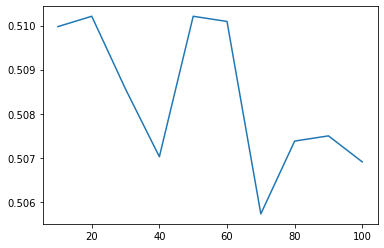

In [34]:
kBest = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
values = []
fs = SelectKBest(score_func = f_classif, k = round((X.shape[1]*0.2)))
X_selected = fs.fit_transform(X, y)
for k in kBest:
    forest = RandomForestClassifier(n_estimators = k, random_state = 0)
    scores = cross_val_score(forest, X, y, cv = 5, n_jobs = 4)
    values.append(scores.mean())
plt.plot(kBest, values);

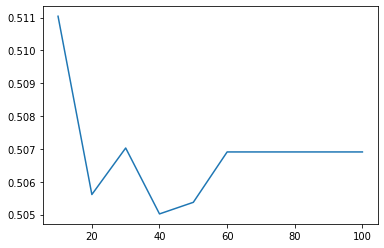

In [35]:
kBest = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
values = []
fs = SelectKBest(score_func = f_classif, k = round((X.shape[1]*0.2)))
X_selected = fs.fit_transform(X, y)
for k in kBest:
    forest = RandomForestClassifier(max_depth = k, random_state = 0)
    scores = cross_val_score(forest, X, y, cv = 5, n_jobs = 4)
    values.append(scores.mean())
plt.plot(kBest, values);

In [29]:
maxFeatures = X_selected.shape[1]
paramGrid = {
      'n_estimators': [i for i in range(1,101,10)],
      'min_samples_split': [i for i in range(5, 51, 5)],
      'min_samples_leaf': [i for i in range(5, 31, 5)],
      'max_depth': [i for i in range(1,51,10)],
      'bootstrap': [0,1],
      'max_samples': [round(0.1*i, 2) for i in range(1, 10)]}
randomGridSearch = RandomizedSearchCV(estimator=RandomForestClassifier(random_state = 0), param_distributions=paramGrid, n_iter=100, scoring=['f1_weighted'], refit = 'f1_weighted', verbose=2, n_jobs=-1)
randomGridSearch.fit(X_selected, y)

n_estimators = []
min_samples_split = []
min_samples_leaf = []
max_depth = []
bootstrap = []
max_samples = []
accuracy = []

#Separa os valores das combinações testadas na busca aleatória por hiperparâmetro
for combination in randomGridSearch.cv_results_['params']:
    n_estimators.append(combination['n_estimators'])
    min_samples_split.append(combination['min_samples_split'])
    min_samples_leaf.append(combination['min_samples_leaf'])
    max_depth.append(combination['max_depth'])
    bootstrap.append(combination['bootstrap'])
    max_samples.append(combination['max_samples'])
f1_scores              = randomGridSearch.cv_results_['mean_test_f1_weighted']

df = pd.DataFrame()
df['n_estimators'] = n_estimators
df['min_samples_split'] = min_samples_split
df['min_samples_leaf'] = min_samples_leaf
df['max_depth'] = max_depth
df['bootstrap'] = bootstrap
df['max_samples'] = max_samples
df['f1_scores'] = f1_scores

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished


In [ ]:
df

In [30]:
df.sort_values(by='f1_scores')

,n_estimators,min_samples_split,min_samples_leaf,max_depth,bootstrap,max_samples,f1_scores
60,41,40,15,1,1,0.6,0.355028
66,51,20,10,1,1,0.7,0.358509
57,41,50,5,1,1,0.7,0.361354
52,41,35,30,1,1,0.1,0.362559
11,51,15,10,1,1,0.8,0.362967
...,...,...,...,...,...,...,...
98,71,25,5,41,0,0.2,0.504624
93,1,35,5,31,1,0.8,0.505516
48,1,40,20,41,0,0.9,0.505777
65,1,10,15,21,1,0.3,0.507963
